To avoid contamination from initialization artifacts, firing rates were computed after discarding an initial transient period (first 200 ms). This ensures that all reported quantities reflect steady-state network dynamics rather than nonstationary behavior induced by arbitrary initial conditions.


In [1]:
import importlib
import model
import numpy as np
importlib.reload(model)
from model.model import network
from model.model import UA_PER_CM2_TO_SI

In [2]:
res= network(
    dt_ms=0.05,
    T_ms=10000.0,
    rng_seed=0,
    gNI_mS_cm2=0.008,
    gEI_mS_cm2=0.08,
    gNE_mS_cm2=0.008,
    gEE_mS_cm2=0.10,
    gIE_mS_cm2=0.25,
    gII_mS_cm2=0.10,
    Iapp_E_uAcm2=4.0,
    Iapp_I_uAcm2=0.0,
    alpha_n_per_ms=0.5
)

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]
INFO       No numerical integration method specified for group 'S_EE', using method 'euler' (took 0.00s, trying other methods took 0.02s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'S_EI', using method 'euler' (took 0.00s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified f

In [3]:
# analysis
lfp = res["lfp"]
t   = res["t_lfp"]

In [4]:
def compute_mean_power(lfp, dt):
    fs=1.0/(dt * 1e-3)
    samples_per_bin = int(1.0 * fs)
    lfp_bins = [
        lfp[i*samples_per_bin:(i+1)*samples_per_bin]
        for i in range(len(lfp) // samples_per_bin)
    ]
    freqs = np.fft.rfftfreq(samples_per_bin, d=1/fs)

    power_bins = []
    for segment in lfp_bins:
        segment = segment - segment.mean()  # DC removal
        fft_vals = np.fft.rfft(segment)
        power = np.abs(fft_vals)**2
        power_bins.append(power)

    mean_power = np.mean(power_bins, axis=0)

    return mean_power,freqs

In [5]:
g = [0.0, 0.006, 0.012, 0.018]

peak_powers = []
peak_freqs  = []

for gg in g:
    res = network(alpha_EI=0.15, dt=0.02, rng_seed=4, gNI_mS_cm2=gg)

    lfp = res["lfp"]
    dt  = res["dt"]

    # FFT analysis (as already implemented)
    freqs, mean_power = compute_mean_power(lfp, dt)

    # Extract scalars
    idx = np.argmax(mean_power)
    f0  = freqs[idx]

    band = (freqs >= f0 - 3) & (freqs <= f0 + 3)
    P0   = np.mean(mean_power[band])

    peak_freqs.append(f0)
    peak_powers.append(P0)


TypeError: network() got an unexpected keyword argument 'alpha_EI'

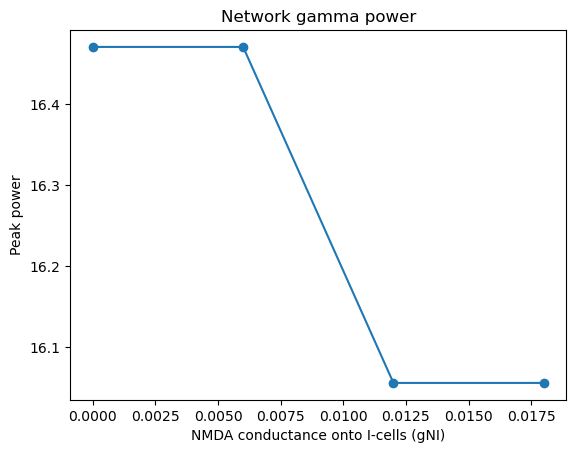

In [24]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(g, peak_powers, 'o-')
plt.xlabel("NMDA conductance onto I-cells (gNI)")
plt.ylabel("Peak power")
plt.title("Network gamma power")
plt.show()


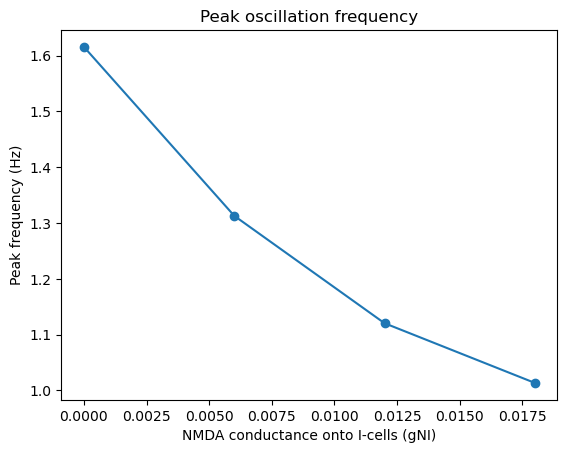

In [25]:
plt.figure()
plt.plot(g, peak_freqs, 'o-')
plt.xlabel("NMDA conductance onto I-cells (gNI)")
plt.ylabel("Peak frequency (Hz)")
plt.title("Peak oscillation frequency")
plt.show()
